<a href="https://colab.research.google.com/github/fms-faisal/Impact-of-Digital-Image-Processing-on-Model-Performance/blob/main/model_selection_part_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


# Mount Google Drive and copy dataset to local storage for faster access [[3]][[4]]
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset to Colab instance storage (runs once)
!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
from tqdm import tqdm

# Use local dataset paths instead of Google Drive [[3]]
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Verify directories exist
assert os.path.exists(TRAIN_DIR), f"Train directory not found: {TRAIN_DIR}"
assert os.path.exists(VAL_DIR), f"Validation directory not found: {VAL_DIR}"
assert os.path.exists(TEST_DIR), f"Test directory not found: {TEST_DIR}"

class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(cls_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase],
                        desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False,
                        dynamic_ncols=True,
                        mininterval=1.0,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():  # Mixed precision [[7]][[8]]
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "best_jute_pest_model.pth"))
            pbar.close()

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

if __name__ == "__main__":
    # Ensure GPU usage [[3]][[5]]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")
    torch.backends.cudnn.benchmark = True  # Optimize convolution algorithms

    # Optimized data transformations [[3]]
    data_transforms = {
        "train": transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.PILToTensor(),  # Faster tensor conversion
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "test": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    # Create datasets
    datasets = {
        "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
        "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
        "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
    }

    # Optimized DataLoader configuration [[3]][[9]]
    batch_size = 64  # Increased batch size for T4 GPU
    num_workers = 8  # Max workers for Colab Pro
    dataloaders = {
        "train": DataLoader(datasets["train"], batch_size=batch_size,
                          shuffle=True, num_workers=num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=4),
        "val": DataLoader(datasets["val"], batch_size=batch_size,
                         shuffle=False, num_workers=num_workers, pin_memory=True,
                         persistent_workers=True, prefetch_factor=4),
        "test": DataLoader(datasets["test"], batch_size=batch_size,
                          shuffle=False, num_workers=num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=4)
    }

    # Model setup with mixed precision [[7]]
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    num_classes = len(datasets["train"].classes)
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)

    # Training setup with mixed precision [[7]]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler()

    # Learning rate scheduler [[7]]
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model, training_logs = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=25,
        device=device
    )

    # Save the final model
    torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_jute_pest_model.pth"))

    # Test evaluation
    model.eval()
    test_results = []
    correct = 0
    total = 0
    sample_idx = 0

    with torch.no_grad():
        pbar_test = tqdm(dataloaders["test"], desc="Testing", leave=False,
                        dynamic_ncols=True, mininterval=1.0,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')
        for images, labels in pbar_test:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                test_results.append({
                    "image_path": datasets["test"].samples[sample_idx][0],
                    "true_label": datasets["test"].classes[labels[i].item()],
                    "predicted_label": datasets["test"].classes[predicted[i].item()]
                })
                sample_idx += 1
        pbar_test.close()

    # Save test results
    with open(os.path.join(BASE_DIR, "test_results.json"), "w") as f:
        json.dump(test_results, f, indent=4)

    # Print test summary
    print("\n--- Test Results ---")
    print(f"Total images tested: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Test Accuracy: {(100 * correct / total):.2f}%")

    # Save training logs
    with open(os.path.join(BASE_DIR, "training_logs.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

Mounted at /content/drive
Using device: cuda:0



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe


Epoch 1/25 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-1-d3111d487103>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision [[7]][[8]]


Train Loss: 0.5064  Acc: 0.8620


Val Loss: 0.4180  Acc: 0.8765

Epoch 2/25 ====================


Train Loss: 0.0621  Acc: 0.9862


Val Loss: 0.3817  Acc: 0.9031

Epoch 3/25 ====================


Train Loss: 0.0238  Acc: 0.9953


Val Loss: 0.3084  Acc: 0.9249

Epoch 4/25 ====================


Train Loss: 0.0136  Acc: 0.9967


Val Loss: 0.3220  Acc: 0.9153

Epoch 5/25 ====================


Train Loss: 0.0105  Acc: 0.9972


Val Loss: 0.2926  Acc: 0.9249

Epoch 6/25 ====================


Train Loss: 0.0101  Acc: 0.9978


Val Loss: 0.3334  Acc: 0.9249

Epoch 7/25 ====================


Train Loss: 0.0036  Acc: 0.9995


Val Loss: 0.3489  Acc: 0.9225

Epoch 8/25 ====================


Train Loss: 0.0035  Acc: 0.9994


Val Loss: 0.3362  Acc: 0.9225

Epoch 9/25 ====================


Train Loss: 0.0021  Acc: 0.9998


Val Loss: 0.3431  Acc: 0.9201

Epoch 10/25 ====================


Train Loss: 0.0040  Acc: 0.9995


Val Loss: 0.3444  Acc: 0.9225

Epoch 11/25 ====================


Train Loss: 0.0033  Acc: 0.9997


Val Loss: 0.3436  Acc: 0.9249

Epoch 12/25 ====================


Train Loss: 0.0028  Acc: 0.9994


Val Loss: 0.3940  Acc: 0.9153

Epoch 13/25 ====================


Train Loss: 0.0021  Acc: 0.9997


Val Loss: 0.3663  Acc: 0.9031

Epoch 14/25 ====================


Train Loss: 0.0017  Acc: 0.9998


Val Loss: 0.3489  Acc: 0.9225

Epoch 15/25 ====================


Train Loss: 0.0011  Acc: 1.0000


Val Loss: 0.3444  Acc: 0.9274

Epoch 16/25 ====================


Train Loss: 0.0012  Acc: 1.0000


Val Loss: 0.3613  Acc: 0.9201

Epoch 17/25 ====================


Train Loss: 0.0014  Acc: 0.9998


Val Loss: 0.3568  Acc: 0.9322

Epoch 18/25 ====================


Train Loss: 0.0013  Acc: 0.9998


Val Loss: 0.3517  Acc: 0.9298

Epoch 19/25 ====================


Train Loss: 0.0026  Acc: 0.9995


Val Loss: 0.3457  Acc: 0.9346

Epoch 20/25 ====================


Train Loss: 0.0017  Acc: 0.9995


Val Loss: 0.4056  Acc: 0.9201

Epoch 21/25 ====================


Train Loss: 0.0050  Acc: 0.9989


Val Loss: 0.3882  Acc: 0.9177

Epoch 22/25 ====================


Train Loss: 0.0011  Acc: 0.9998


Val Loss: 0.3639  Acc: 0.9274

Epoch 23/25 ====================


Train Loss: 0.0009  Acc: 0.9998


Val Loss: 0.3722  Acc: 0.9201

Epoch 24/25 ====================


Train Loss: 0.0007  Acc: 1.0000


Val Loss: 0.3645  Acc: 0.9225

Epoch 25/25 ====================


Train Loss: 0.0008  Acc: 1.0000


Val Loss: 0.3776  Acc: 0.9153

Training complete in 11m 32s
Best validation accuracy: 0.9346



--- Test Results ---
Total images tested: 379
Correct predictions: 373
Test Accuracy: 98.42%


***Resnet50***

In [ ]:


# Mount Google Drive and copy dataset to local storage for faster access [[3]][[4]]
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset to Colab instance storage
!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
from tqdm import tqdm

# Use local dataset paths instead of Google Drive [[3]]
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Verify directories exist
assert os.path.exists(TRAIN_DIR), f"Train directory not found: {TRAIN_DIR}"
assert os.path.exists(VAL_DIR), f"Validation directory not found: {VAL_DIR}"
assert os.path.exists(TEST_DIR), f"Test directory not found: {TEST_DIR}"

class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(cls_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase],
                        desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False,
                        dynamic_ncols=True,
                        mininterval=1.0,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():  # Mixed precision [[7]][[8]]
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "best_jute_pest_model.pth"))
            pbar.close()

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

if __name__ == "__main__":
    # Ensure GPU usage [[3]][[5]]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")
    torch.backends.cudnn.benchmark = True  # Optimize convolution algorithms

    # Optimized data transformations [[3]]
    data_transforms = {
        "train": transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.PILToTensor(),  # Faster tensor conversion
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "test": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    # Create datasets
    datasets = {
        "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
        "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
        "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
    }

    # Optimized DataLoader configuration [[3]][[9]]
    batch_size = 64  # Increased batch size for T4 GPU
    num_workers = 8  # Max workers for Colab Pro
    dataloaders = {
        "train": DataLoader(datasets["train"], batch_size=batch_size,
                          shuffle=True, num_workers=num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=4),
        "val": DataLoader(datasets["val"], batch_size=batch_size,
                         shuffle=False, num_workers=num_workers, pin_memory=True,
                         persistent_workers=True, prefetch_factor=4),
        "test": DataLoader(datasets["test"], batch_size=batch_size,
                          shuffle=False, num_workers=num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=4)
    }

    # Model setup with mixed precision [[7]]
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    num_classes = len(datasets["train"].classes)
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)

    # Training setup with mixed precision [[7]]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler()

    # Learning rate scheduler [[7]]
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model, training_logs = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=15,
        device=device
    )

    # Save the final model
    torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_jute_pest_model.pth"))

    # Test evaluation
    model.eval()
    test_results = []
    correct = 0
    total = 0
    sample_idx = 0

    with torch.no_grad():
        pbar_test = tqdm(dataloaders["test"], desc="Testing", leave=False,
                        dynamic_ncols=True, mininterval=1.0,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')
        for images, labels in pbar_test:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                test_results.append({
                    "image_path": datasets["test"].samples[sample_idx][0],
                    "true_label": datasets["test"].classes[labels[i].item()],
                    "predicted_label": datasets["test"].classes[predicted[i].item()]
                })
                sample_idx += 1
        pbar_test.close()

    # Save test results
    with open(os.path.join(BASE_DIR, "test_results.json"), "w") as f:
        json.dump(test_results, f, indent=4)

    # Print test summary
    print("\n--- Test Results ---")
    print(f"Total images tested: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Test Accuracy: {(100 * correct / total):.2f}%")

    # Save training logs
    with open(os.path.join(BASE_DIR, "training_logs.json"), "w") as f:
        json.dump(training_logs, f, indent=4)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists
Using device: cuda:0



<ipython-input-2-48bb1ace848e>:177: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/15 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-2-48bb1ace848e>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision [[7]][[8]]


Train Loss: 0.5390  Acc: 0.8408


Val Loss: 0.3552  Acc: 0.8935

Epoch 2/15 ====================


Train Loss: 0.0615  Acc: 0.9845


Val Loss: 0.3009  Acc: 0.9274

Epoch 3/15 ====================


Train Loss: 0.0279  Acc: 0.9919


Val Loss: 0.3309  Acc: 0.9031

Epoch 4/15 ====================


Train Loss: 0.0171  Acc: 0.9963


Val Loss: 0.3293  Acc: 0.9080

Epoch 5/15 ====================


Train Loss: 0.0083  Acc: 0.9991


Val Loss: 0.3058  Acc: 0.9298

Epoch 6/15 ====================


Train Loss: 0.0062  Acc: 0.9986


Val Loss: 0.3124  Acc: 0.9274

Epoch 7/15 ====================


Train Loss: 0.0056  Acc: 0.9986


Val Loss: 0.3387  Acc: 0.9249

Epoch 8/15 ====================


Train Loss: 0.0041  Acc: 0.9997


Val Loss: 0.3426  Acc: 0.9201

Epoch 9/15 ====================


Train Loss: 0.0020  Acc: 1.0000


Val Loss: 0.3474  Acc: 0.9298

Epoch 10/15 ====================


Train Loss: 0.0019  Acc: 1.0000


Val Loss: 0.3363  Acc: 0.9346

Epoch 11/15 ====================


Train Loss: 0.0028  Acc: 0.9995


Val Loss: 0.3203  Acc: 0.9322

Epoch 12/15 ====================


Train Loss: 0.0022  Acc: 0.9997


Val Loss: 0.3649  Acc: 0.9225

Epoch 13/15 ====================


Train Loss: 0.0022  Acc: 0.9997


Val Loss: 0.3486  Acc: 0.9370

Epoch 14/15 ====================


Train Loss: 0.0020  Acc: 0.9998


Val Loss: 0.3446  Acc: 0.9225

Epoch 15/15 ====================


Train Loss: 0.0051  Acc: 0.9989


Val Loss: 0.3541  Acc: 0.9298

Training complete in 6m 58s
Best validation accuracy: 0.9370



--- Test Results ---
Total images tested: 379
Correct predictions: 375
Test Accuracy: 98.94%


# **ResNet18**

Mounted at /content/drive
Using device: cuda:0



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe


Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-3-d38ac81cc149>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Train Loss: 0.5238  Acc: 0.8496


Val Loss: 0.4265  Acc: 0.8983

Epoch 2/10 ====================


Train Loss: 0.0652  Acc: 0.9829


Val Loss: 0.3682  Acc: 0.9031

Epoch 3/10 ====================


Train Loss: 0.0301  Acc: 0.9918


Val Loss: 0.4342  Acc: 0.8959

Epoch 4/10 ====================


Train Loss: 0.0228  Acc: 0.9943


Val Loss: 0.3589  Acc: 0.9153

Epoch 5/10 ====================


Train Loss: 0.0131  Acc: 0.9971


Val Loss: 0.3558  Acc: 0.9201

Epoch 6/10 ====================


Train Loss: 0.0050  Acc: 0.9998


Val Loss: 0.3322  Acc: 0.9177

Epoch 7/10 ====================


Train Loss: 0.0045  Acc: 0.9997


Val Loss: 0.3145  Acc: 0.9274

Epoch 8/10 ====================


Train Loss: 0.0054  Acc: 0.9988


Val Loss: 0.3336  Acc: 0.9370

Epoch 9/10 ====================


Train Loss: 0.0075  Acc: 0.9981


Val Loss: 0.3651  Acc: 0.9225

Epoch 10/10 ====================


Train Loss: 0.0042  Acc: 0.9997


Val Loss: 0.3633  Acc: 0.9298

Training complete in 4m 38s
Best validation accuracy: 0.9370



--- Test Metrics ---
Test Accuracy : 0.9842
Precision     : 0.9847
Recall        : 0.9842
F1 Score      : 0.9840

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.94      0.85      0.89        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.95      1.00      0.98        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.96      1.00      0.98        22
                   Jute Hairy       0.91      1.00      0.95        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

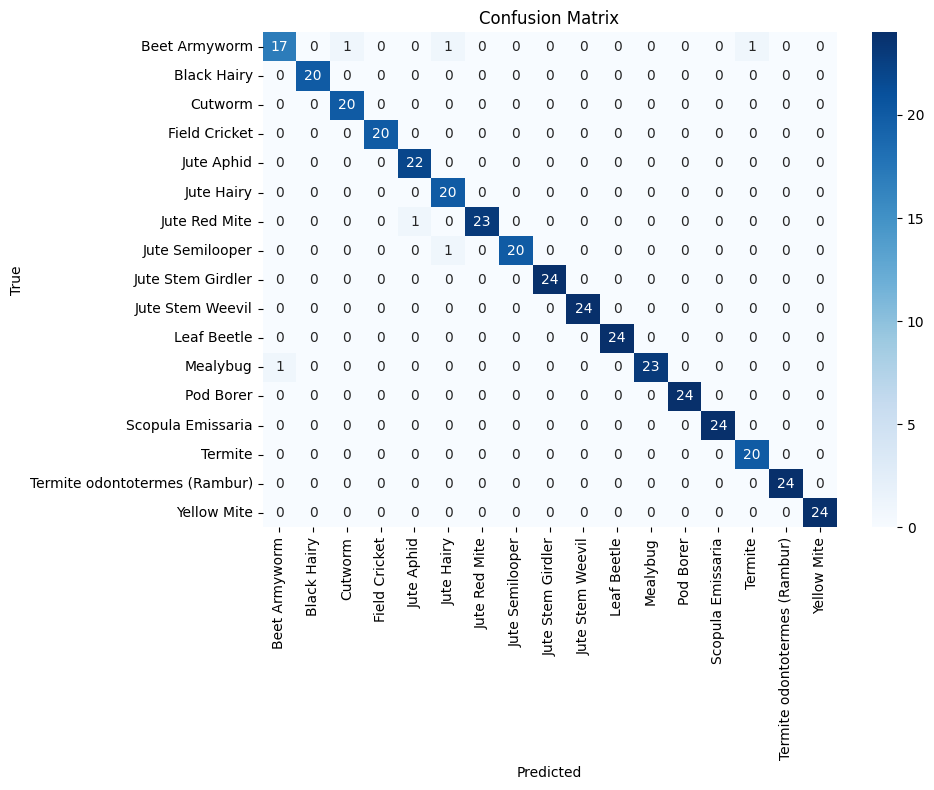

In [ ]:

# Mount Google Drive and copy dataset to local storage for faster access [[3]][[4]]
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset to Colab instance storage
!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Use local dataset paths instead of Google Drive [[3]]
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Verify directories exist
assert os.path.exists(TRAIN_DIR), f"Train directory not found: {TRAIN_DIR}"
assert os.path.exists(VAL_DIR), f"Validation directory not found: {VAL_DIR}"
assert os.path.exists(TEST_DIR), f"Test directory not found: {TEST_DIR}"

class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(cls_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase],
                        desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False,
                        dynamic_ncols=True,
                        mininterval=1.0,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():  # Mixed precision
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "best_jute_pest_model.pth"))
            pbar.close()

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")
    torch.backends.cudnn.benchmark = True

    data_transforms = {
        "train": transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "test": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    datasets = {
        "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
        "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
        "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
    }

    batch_size = 64
    num_workers = 8
    dataloaders = {
        "train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True,
                            num_workers=num_workers, pin_memory=True,
                            persistent_workers=True, prefetch_factor=4),
        "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=4),
        "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True,
                           persistent_workers=True, prefetch_factor=4)
    }

    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    num_classes = len(datasets["train"].classes)
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler()

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, training_logs = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device
    )

    torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_jute_pest_model.pth"))

    # --- Enhanced Test Evaluation ---
    model.eval()
    test_results = []
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    sample_idx = 0

    with torch.no_grad():
        pbar_test = tqdm(dataloaders["test"], desc="Testing", leave=False,
                         dynamic_ncols=True, mininterval=1.0,
                         bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')
        for images, labels in pbar_test:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                test_results.append({
                    "image_path": datasets["test"].samples[sample_idx][0],
                    "true_label": datasets["test"].classes[labels[i].item()],
                    "predicted_label": datasets["test"].classes[predicted[i].item()]
                })
                sample_idx += 1
        pbar_test.close()

    # Save test results
    with open(os.path.join(BASE_DIR, "test_results.json"), "w") as f:
        json.dump(test_results, f, indent=4)

    # Print test summary
    print("\n--- Test Metrics ---")
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Test Accuracy : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

    # Confusion matrix heatmap
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=datasets["test"].classes, yticklabels=datasets["test"].classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "confusion_matrix.png"))
    plt.show()

    # Save training logs
    with open(os.path.join(BASE_DIR, "training_logs.json"), "w") as f:
        json.dump(training_logs, f, indent=4)


# **ResNet50**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists
Using device: cuda:0



<ipython-input-5-6259f2aac7c9>:184: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-5-6259f2aac7c9>:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.4938  Acc: 0.8571


Val Loss: 0.5296  Acc: 0.8789

Epoch 2/10 ====================


Train Loss: 0.0580  Acc: 0.9822


Val Loss: 0.4095  Acc: 0.8935

Epoch 3/10 ====================


Train Loss: 0.0279  Acc: 0.9919


Val Loss: 0.4331  Acc: 0.9201

Epoch 4/10 ====================


Train Loss: 0.0249  Acc: 0.9927


Val Loss: 0.4318  Acc: 0.9201

Epoch 5/10 ====================


Train Loss: 0.0224  Acc: 0.9938


Val Loss: 0.3622  Acc: 0.9201

Epoch 6/10 ====================


Train Loss: 0.0104  Acc: 0.9977


Val Loss: 0.3226  Acc: 0.9274

Epoch 7/10 ====================


Train Loss: 0.0126  Acc: 0.9974


Val Loss: 0.3453  Acc: 0.9346

Epoch 8/10 ====================


Train Loss: 0.0121  Acc: 0.9967


Val Loss: 0.3540  Acc: 0.9346

Epoch 9/10 ====================


Train Loss: 0.0049  Acc: 0.9989


Val Loss: 0.3583  Acc: 0.9249

Epoch 10/10 ====================


Train Loss: 0.0042  Acc: 0.9991


Val Loss: 0.4061  Acc: 0.9274

Training complete in 5m 50s
Best validation accuracy: 0.9346



--- Test Metrics ---
Test Accuracy : 0.9763
Precision     : 0.9795
Recall        : 0.9763
F1 Score      : 0.9757

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.95      0.90      0.92        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.95      1.00      0.98        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       1.00      1.00      1.00        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       1.00      0.71      0.83        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

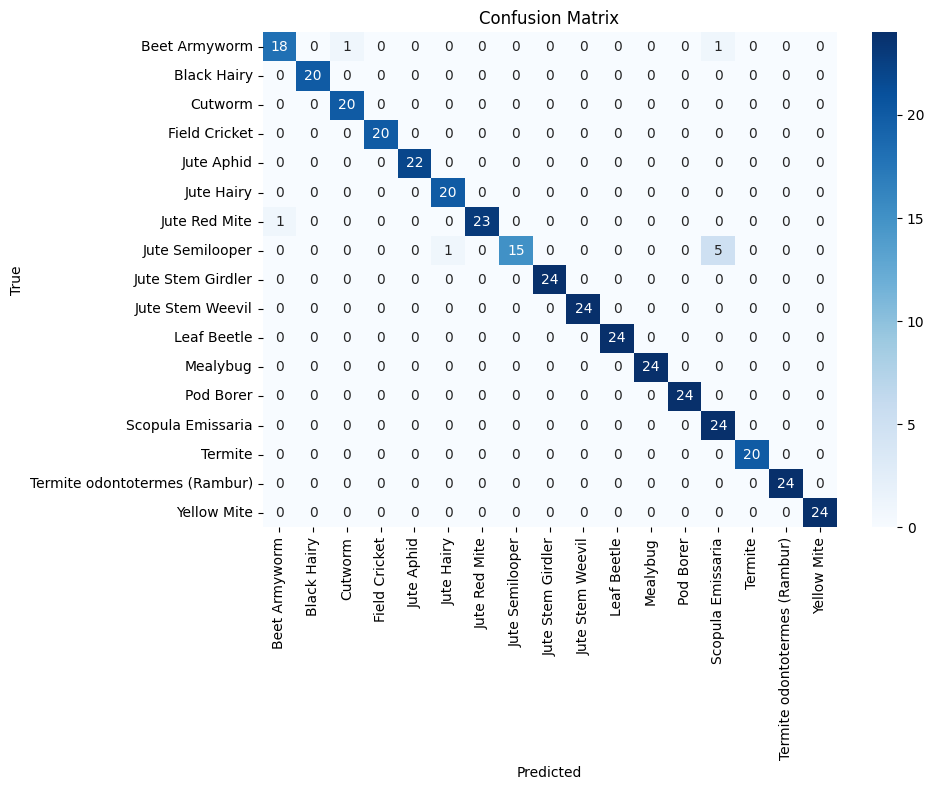


--- Sample Predictions ---


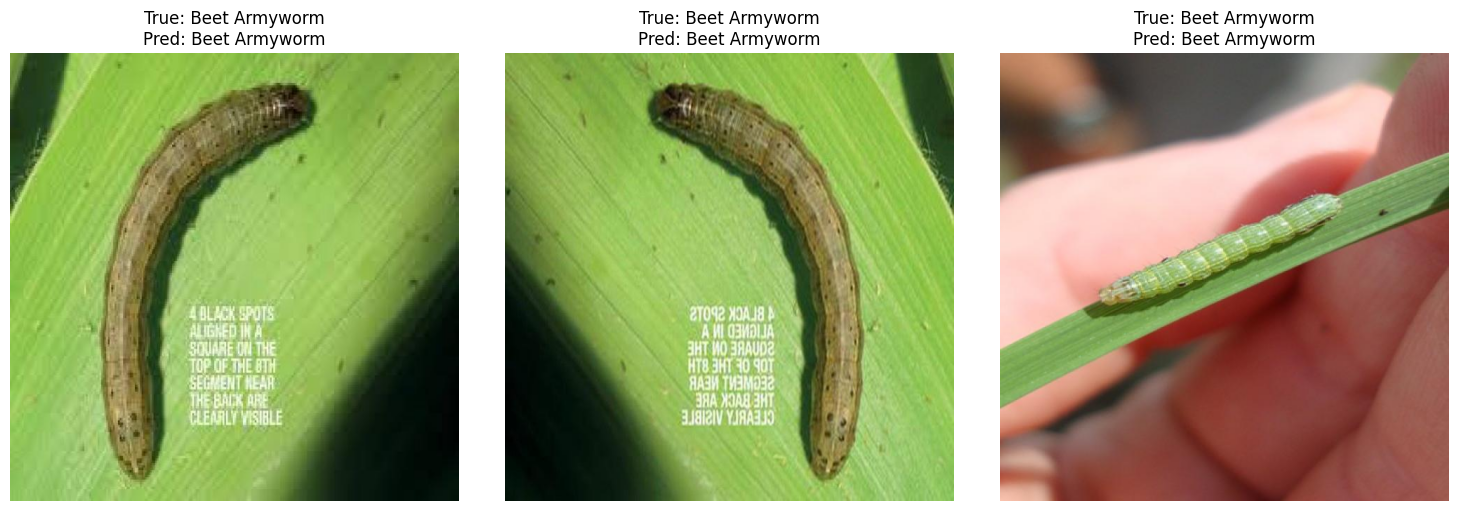

In [ ]:
# Google Colab: Mount Drive and Copy Dataset
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# Imports
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Paths
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")
assert os.path.exists(TRAIN_DIR)
assert os.path.exists(VAL_DIR)
assert os.path.exists(TEST_DIR)

# Dataset Class
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(cls_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Training Function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase],
                        desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False,
                        dynamic_ncols=True,
                        mininterval=1.0,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "resnet_50_best_jute_pest_model.pth"))
            pbar.close()

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# Main Code
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")
    torch.backends.cudnn.benchmark = True

    # Transforms
    data_transforms = {
        "train": transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        "test": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    }

    datasets = {
        "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
        "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
        "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
    }

    batch_size = 64
    num_workers = 8
    dataloaders = {
        "train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True,
                            num_workers=num_workers, pin_memory=True,
                            persistent_workers=True, prefetch_factor=4),
        "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=4),
        "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True,
                           persistent_workers=True, prefetch_factor=4)
    }

    # === ResNet50 Model ===
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(datasets["train"].classes))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, training_logs = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device
    )

    torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_jute_pest_model.pth"))

    # === Test Phase ===
    model.eval()
    test_results = []
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    sample_idx = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                test_results.append({
                    "image_path": datasets["test"].samples[sample_idx][0],
                    "true_label": datasets["test"].classes[labels[i].item()],
                    "predicted_label": datasets["test"].classes[predicted[i].item()]
                })
                sample_idx += 1

    # Save test results
    with open(os.path.join(BASE_DIR, "resnet_50_test_results.json"), "w") as f:
        json.dump(test_results, f, indent=4)

    # Metrics
    print("\n--- Test Metrics ---")
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Test Accuracy : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=datasets["test"].classes,
                yticklabels=datasets["test"].classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "resnet_50_confusion_matrix.png"))
    plt.show()

    # === Show 3 Sample Predictions ===
    print("\n--- Sample Predictions ---")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axes):
        sample = test_results[i]
        img = Image.open(sample["image_path"])
        ax.imshow(img)
        ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "resnet_50_sample_predictions.png"))
    plt.show()

    # Save training log
    with open(os.path.join(BASE_DIR, "resnet_50_training_logs.json"), "w") as f:
        json.dump(training_logs, f, indent=4)


# ***AlexNet***

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists
Using device: cuda:0



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNe


Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-6-72210f7cf834>:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.8809  Acc: 0.7323


Val Loss: 0.9505  Acc: 0.7409

Epoch 2/10 ====================


Train Loss: 0.4342  Acc: 0.8636


Val Loss: 0.8702  Acc: 0.7942

Epoch 3/10 ====================


Train Loss: 0.2679  Acc: 0.9182


Val Loss: 0.6058  Acc: 0.8402

Epoch 4/10 ====================


Train Loss: 0.1920  Acc: 0.9416


Val Loss: 0.7103  Acc: 0.8184

Epoch 5/10 ====================


Train Loss: 0.1738  Acc: 0.9488


Val Loss: 0.7225  Acc: 0.8523

Epoch 6/10 ====================


Train Loss: 0.1680  Acc: 0.9452


Val Loss: 0.8145  Acc: 0.8402

Epoch 7/10 ====================


Train Loss: 0.1406  Acc: 0.9562


Val Loss: 0.7505  Acc: 0.8668

Epoch 8/10 ====================


Train Loss: 0.0898  Acc: 0.9718


Val Loss: 0.7847  Acc: 0.8523

Epoch 9/10 ====================


Train Loss: 0.0824  Acc: 0.9738


Val Loss: 0.8426  Acc: 0.8547

Epoch 10/10 ====================


Train Loss: 0.0774  Acc: 0.9719


Val Loss: 0.9667  Acc: 0.8111

Training complete in 4m 24s
Best validation accuracy: 0.8668



--- Test Metrics ---
Test Accuracy : 0.9631
Precision     : 0.9649
Recall        : 0.9631
F1 Score      : 0.9619

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.94      0.75      0.83        20
                  Black Hairy       0.95      1.00      0.98        20
                      Cutworm       0.91      1.00      0.95        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.85      1.00      0.92        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      0.79      0.88        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       0.96      1.00      0.98        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       0.96      1.00      0.98        24
         

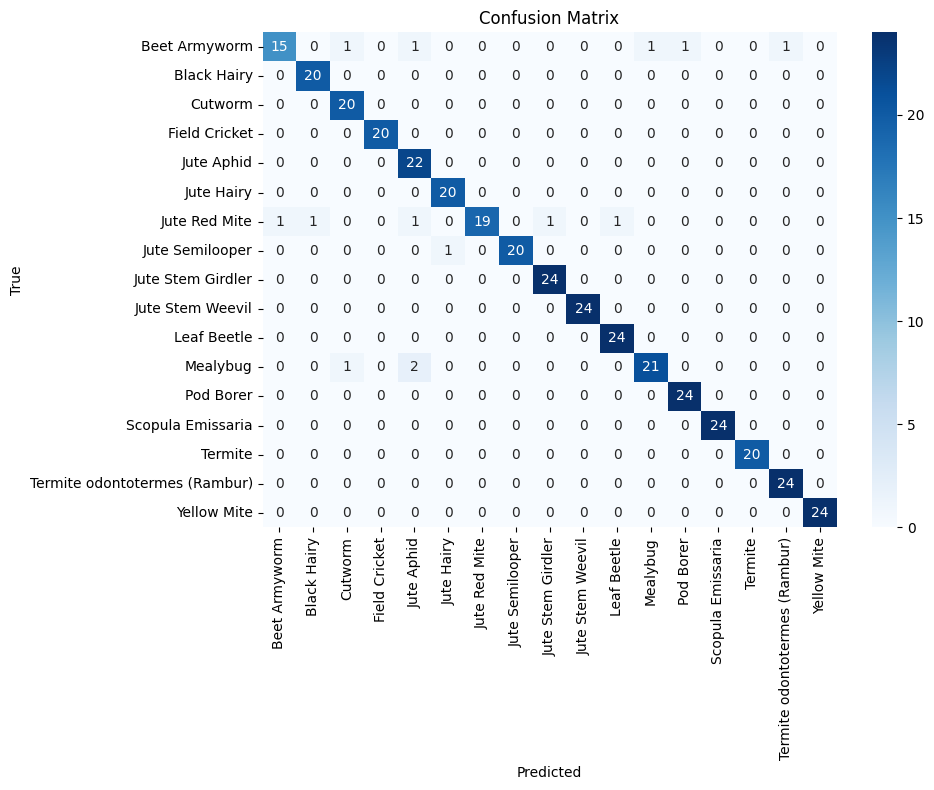


--- Sample Predictions ---


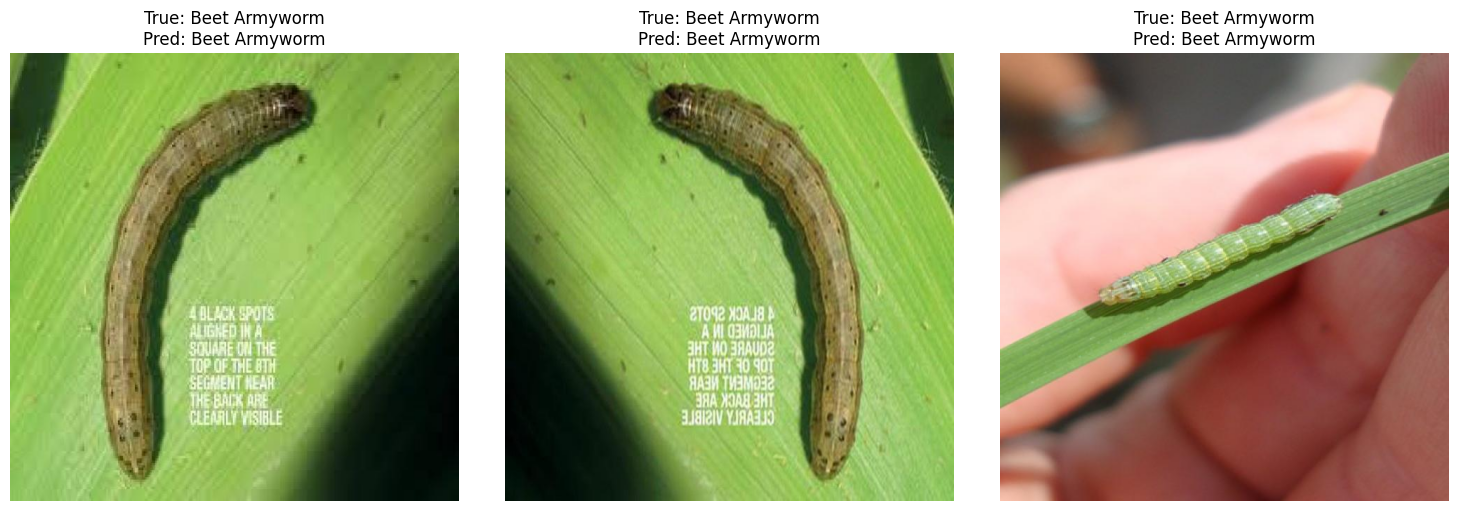

In [ ]:
# Google Colab: Mount Drive and Copy Dataset
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# Imports
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Paths
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")
assert os.path.exists(TRAIN_DIR)
assert os.path.exists(VAL_DIR)
assert os.path.exists(TEST_DIR)

# Dataset Class
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(cls_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Training Function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase],
                        desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False,
                        dynamic_ncols=True,
                        mininterval=1.0,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "alexnet_best_jute_pest_model.pth"))
            pbar.close()

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# Main Code
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")
    torch.backends.cudnn.benchmark = True

    # Transforms
    data_transforms = {
        "train": transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        "test": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    }

    datasets = {
        "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
        "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
        "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
    }

    batch_size = 64
    num_workers = 8
    dataloaders = {
        "train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True,
                            num_workers=num_workers, pin_memory=True,
                            persistent_workers=True, prefetch_factor=4),
        "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=4),
        "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True,
                           persistent_workers=True, prefetch_factor=4)
    }

    # === AlexNet Model ===
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(datasets["train"].classes))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, training_logs = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device
    )

    torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_jute_pest_model.pth"))

    # === Test Phase ===
    model.eval()
    test_results = []
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    sample_idx = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                test_results.append({
                    "image_path": datasets["test"].samples[sample_idx][0],
                    "true_label": datasets["test"].classes[labels[i].item()],
                    "predicted_label": datasets["test"].classes[predicted[i].item()]
                })
                sample_idx += 1

    # Save test results
    with open(os.path.join(BASE_DIR, "alexnet_test_results.json"), "w") as f:
        json.dump(test_results, f, indent=4)

    # Metrics
    print("\n--- Test Metrics ---")
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Test Accuracy : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=datasets["test"].classes,
                yticklabels=datasets["test"].classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "alexnet_confusion_matrix.png"))
    plt.show()

    # === Show 3 Sample Predictions ===
    print("\n--- Sample Predictions ---")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axes):
        sample = test_results[i]
        img = Image.open(sample["image_path"])
        ax.imshow(img)
        ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "alexnet_sample_predictions.png"))
    plt.show()

    # Save training log
    with open(os.path.join(BASE_DIR, "alexnet_training_logs.json"), "w") as f:
        json.dump(training_logs, f, indent=4)


# ***DenseNet-121***

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists
Using device: cuda:0



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=De


Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-7-779b72614108>:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.4722  Acc: 0.8684


Val Loss: 0.3110  Acc: 0.9080

Epoch 2/10 ====================


Train Loss: 0.0414  Acc: 0.9894


Val Loss: 0.2839  Acc: 0.9298

Epoch 3/10 ====================


Train Loss: 0.0219  Acc: 0.9946


Val Loss: 0.3069  Acc: 0.9346

Epoch 4/10 ====================


Train Loss: 0.0109  Acc: 0.9975


Val Loss: 0.3244  Acc: 0.9346

Epoch 5/10 ====================


Train Loss: 0.0083  Acc: 0.9983


Val Loss: 0.2971  Acc: 0.9395

Epoch 6/10 ====================


Train Loss: 0.0054  Acc: 0.9988


Val Loss: 0.3307  Acc: 0.9346

Epoch 7/10 ====================


Train Loss: 0.0052  Acc: 0.9986


Val Loss: 0.3215  Acc: 0.9346

Epoch 8/10 ====================


Train Loss: 0.0044  Acc: 0.9994


Val Loss: 0.3198  Acc: 0.9322

Epoch 9/10 ====================


Train Loss: 0.0027  Acc: 0.9994


Val Loss: 0.3196  Acc: 0.9395

Epoch 10/10 ====================


Train Loss: 0.0018  Acc: 0.9997


Val Loss: 0.3064  Acc: 0.9419

Training complete in 7m 4s
Best validation accuracy: 0.9419



--- Test Metrics ---
Test Accuracy : 0.9789
Precision     : 0.9818
Recall        : 0.9789
F1 Score      : 0.9782

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       1.00      0.90      0.95        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.91      1.00      0.95        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       1.00      1.00      1.00        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      1.00      1.00        24
              Jute Semilooper       1.00      0.71      0.83        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

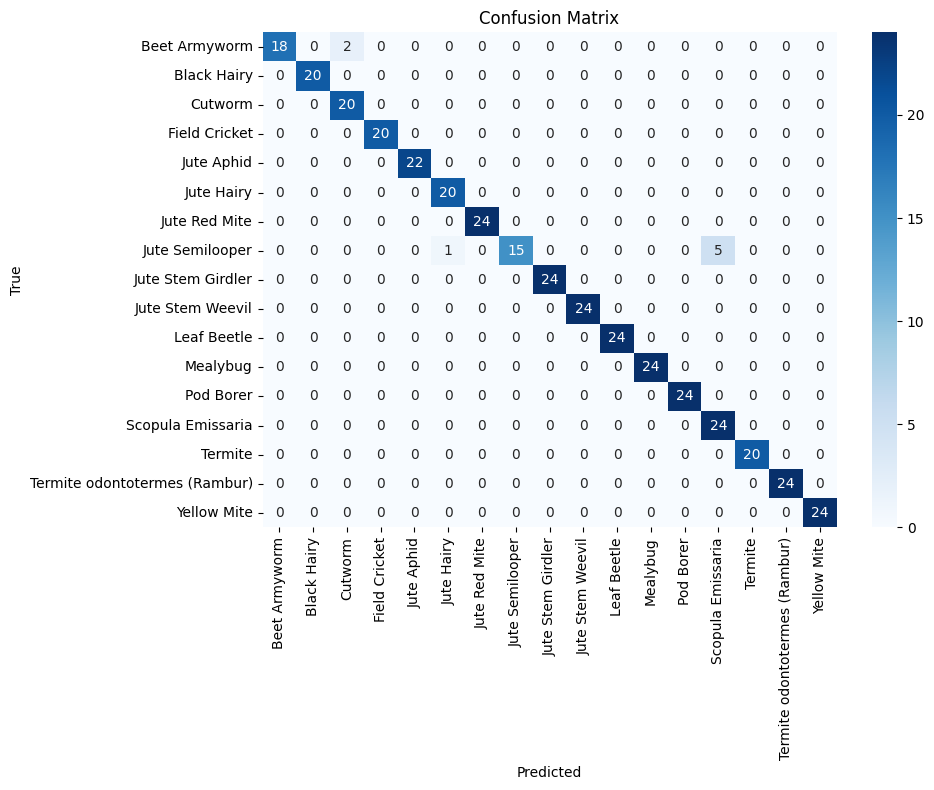


--- Sample Predictions ---


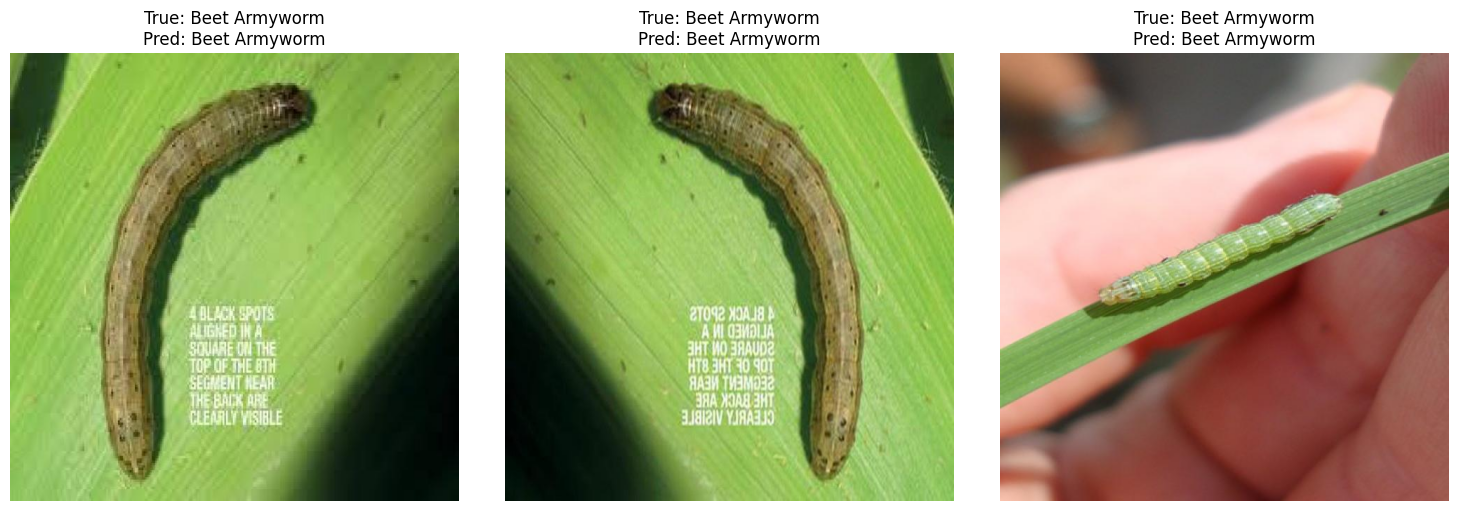

In [ ]:
# Google Colab: Mount Drive and Copy Dataset
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# Imports
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Paths
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")
assert os.path.exists(TRAIN_DIR)
assert os.path.exists(VAL_DIR)
assert os.path.exists(TEST_DIR)

# Dataset Class
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(cls_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Training Function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase],
                        desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False,
                        dynamic_ncols=True,
                        mininterval=1.0,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "densenet_best_jute_pest_model.pth"))
            pbar.close()

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# Main Code
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")
    torch.backends.cudnn.benchmark = True

    # Transforms
    data_transforms = {
        "train": transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        "test": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    }

    datasets = {
        "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
        "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
        "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
    }

    batch_size = 64
    num_workers = 8
    dataloaders = {
        "train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True,
                            num_workers=num_workers, pin_memory=True,
                            persistent_workers=True, prefetch_factor=4),
        "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True,
                          persistent_workers=True, prefetch_factor=4),
        "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True,
                           persistent_workers=True, prefetch_factor=4)
    }

    # === DenseNet Model ===
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(datasets["train"].classes))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, training_logs = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device
    )

    torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_densenet_jute_pest_model.pth"))

    # === Test Phase ===
    model.eval()
    test_results = []
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    sample_idx = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                test_results.append({
                    "image_path": datasets["test"].samples[sample_idx][0],
                    "true_label": datasets["test"].classes[labels[i].item()],
                    "predicted_label": datasets["test"].classes[predicted[i].item()]
                })
                sample_idx += 1

    with open(os.path.join(BASE_DIR, "densenet_test_results.json"), "w") as f:
        json.dump(test_results, f, indent=4)

    # Metrics
    print("\n--- Test Metrics ---")
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Test Accuracy : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=datasets["test"].classes,
                yticklabels=datasets["test"].classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "densenet_confusion_matrix.png"))
    plt.show()

    # Sample Predictions
    print("\n--- Sample Predictions ---")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axes):
        sample = test_results[i]
        img = Image.open(sample["image_path"])
        ax.imshow(img)
        ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
        ax.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "densenet_sample_predictions.png"))
    plt.show()

    with open(os.path.join(BASE_DIR, "densenet_training_logs.json"), "w") as f:
        json.dump(training_logs, f, indent=4)


# ***EfficientNet***

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists
Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weight


Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-8-4a441f2e2159>:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.9242  Acc: 0.7658


Val Loss: 0.4038  Acc: 0.8935

Epoch 2/10 ====================


Train Loss: 0.1003  Acc: 0.9766


Val Loss: 0.2934  Acc: 0.9128

Epoch 3/10 ====================


Train Loss: 0.0460  Acc: 0.9890


Val Loss: 0.2985  Acc: 0.9153

Epoch 4/10 ====================


Train Loss: 0.0237  Acc: 0.9964


Val Loss: 0.2745  Acc: 0.9395

Epoch 5/10 ====================


Train Loss: 0.0201  Acc: 0.9947


Val Loss: 0.2988  Acc: 0.9298

Epoch 6/10 ====================


Train Loss: 0.0133  Acc: 0.9975


Val Loss: 0.2951  Acc: 0.9322

Epoch 7/10 ====================


Train Loss: 0.0114  Acc: 0.9974


Val Loss: 0.2922  Acc: 0.9322

Epoch 8/10 ====================


Train Loss: 0.0120  Acc: 0.9974


Val Loss: 0.2973  Acc: 0.9370

Epoch 9/10 ====================


Train Loss: 0.0124  Acc: 0.9974


Val Loss: 0.3093  Acc: 0.9274

Epoch 10/10 ====================


Train Loss: 0.0061  Acc: 0.9994


Val Loss: 0.3297  Acc: 0.9274

Training complete in 5m 42s
Best validation accuracy: 0.9395



--- Test Metrics ---
Test Accuracy : 0.9789
Precision     : 0.9799
Recall        : 0.9789
F1 Score      : 0.9787

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.95      0.90      0.92        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.91      1.00      0.95        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.88      1.00      0.94        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

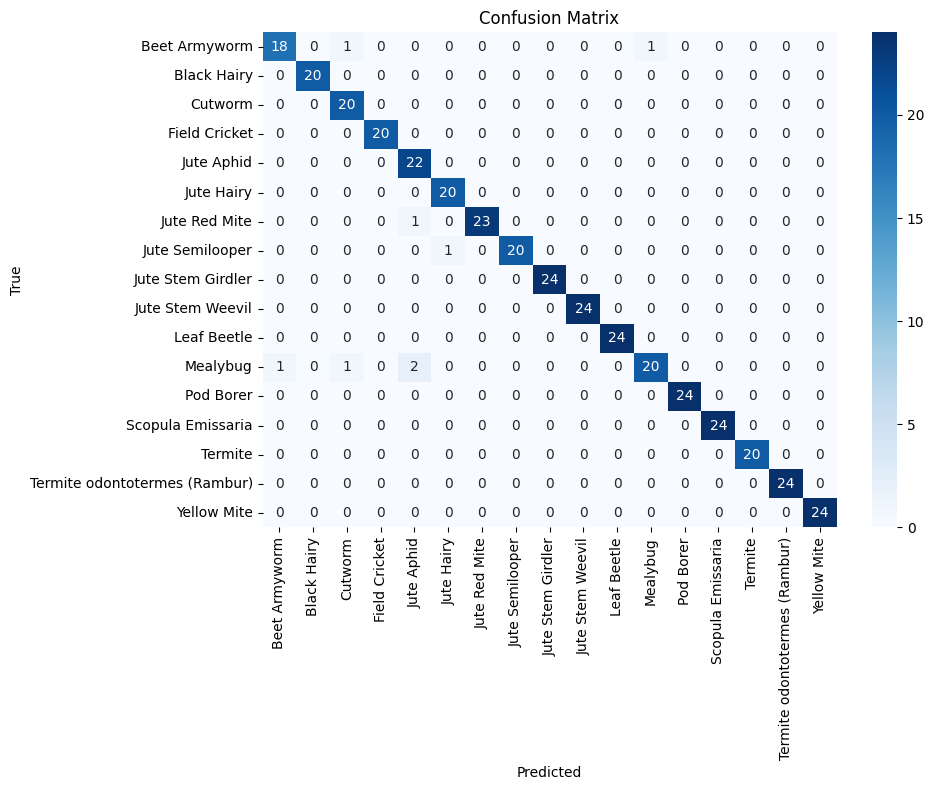


--- Sample Predictions (3 random classes) ---


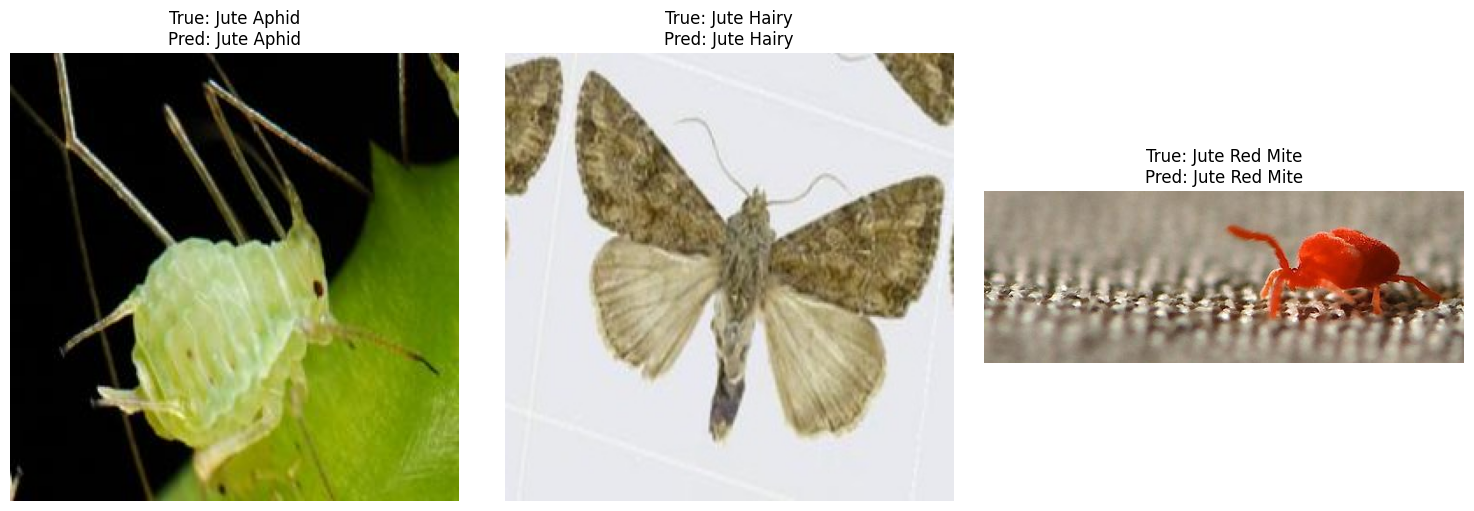

In [ ]:
# Google Colab: Mount Drive and Copy Dataset
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# Imports
import os
import time
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Paths
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Dataset Class
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Training Function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase],
                        desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False,
                        dynamic_ncols=True,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "efficientnet_best_jute_pest_model.pth"))

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# === MAIN CODE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}\n")

# Transforms
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Datasets & Dataloaders
datasets = {
    "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
    "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
    "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
}

batch_size = 64
num_workers = 8
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size, shuffle=(phase=="train"),
                      num_workers=num_workers, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    for phase in ["train", "val", "test"]
}

# === EfficientNet ===
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(datasets["train"].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# Train
model, training_logs = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_efficientnet_jute_pest_model.pth"))

# === TEST ===
model.eval()
test_results, all_preds, all_labels = [], [], []
correct, total, sample_idx = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            test_results.append({
                "image_path": datasets["test"].samples[sample_idx][0],
                "true_label": datasets["test"].classes[labels[i].item()],
                "predicted_label": datasets["test"].classes[predicted[i].item()]
            })
            sample_idx += 1

# Save Results
with open(os.path.join(BASE_DIR, "efficientnet_test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# Metrics
print("\n--- Test Metrics ---")
print(f"Test Accuracy : {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision     : {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall        : {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"F1 Score      : {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=datasets["test"].classes,
            yticklabels=datasets["test"].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "efficientnet_confusion_matrix.png"))
plt.show()

# Random Predictions: 3 classes
chosen_classes = random.sample(datasets["test"].classes, 3)
chosen_samples = []

for cls in chosen_classes:
    cls_indices = [i for i, sample in enumerate(test_results) if sample["true_label"] == cls]
    if cls_indices:
        chosen_samples.append(test_results[random.choice(cls_indices)])

print("\n--- Sample Predictions (3 random classes) ---")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sample = chosen_samples[i]
    img = Image.open(sample["image_path"])
    ax.imshow(img)
    ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "efficientnet_sample_predictions.png"))
plt.show()

# Save training logs
with open(os.path.join(BASE_DIR, "efficientnet_training_logs.json"), "w") as f:
    json.dump(training_logs, f, indent=4)


# ***VGG 16***

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists
Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_We


Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-9-d75e08c201d5>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.5479  Acc: 0.8338


Val Loss: 0.4961  Acc: 0.8741

Epoch 2/10 ====================


Train Loss: 0.1539  Acc: 0.9544


Val Loss: 0.4961  Acc: 0.8717

Epoch 3/10 ====================


Train Loss: 0.0873  Acc: 0.9741


Val Loss: 0.5118  Acc: 0.8983

Epoch 4/10 ====================


Train Loss: 0.0585  Acc: 0.9826


Val Loss: 0.5430  Acc: 0.8741

Epoch 5/10 ====================


Train Loss: 0.0383  Acc: 0.9882


Val Loss: 0.5162  Acc: 0.8886

Epoch 6/10 ====================


Train Loss: 0.0409  Acc: 0.9877


Val Loss: 0.5684  Acc: 0.8789

Epoch 7/10 ====================


Train Loss: 0.0323  Acc: 0.9908


Val Loss: 0.4863  Acc: 0.9007

Epoch 8/10 ====================


Train Loss: 0.0185  Acc: 0.9946


Val Loss: 0.5674  Acc: 0.8862

Epoch 9/10 ====================


Train Loss: 0.0173  Acc: 0.9946


Val Loss: 0.5545  Acc: 0.8983

Epoch 10/10 ====================


Train Loss: 0.0180  Acc: 0.9949


Val Loss: 0.5099  Acc: 0.8983

Training complete in 5m 40s
Best validation accuracy: 0.9007



--- Test Metrics ---
Test Accuracy : 0.9710
Precision     : 0.9727
Recall        : 0.9710
F1 Score      : 0.9710

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.89      0.85      0.87        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.83      1.00      0.91        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       1.00      1.00      1.00        22
                   Jute Hairy       1.00      0.95      0.97        20
                Jute Red Mite       0.96      0.96      0.96        24
              Jute Semilooper       0.95      0.90      0.93        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

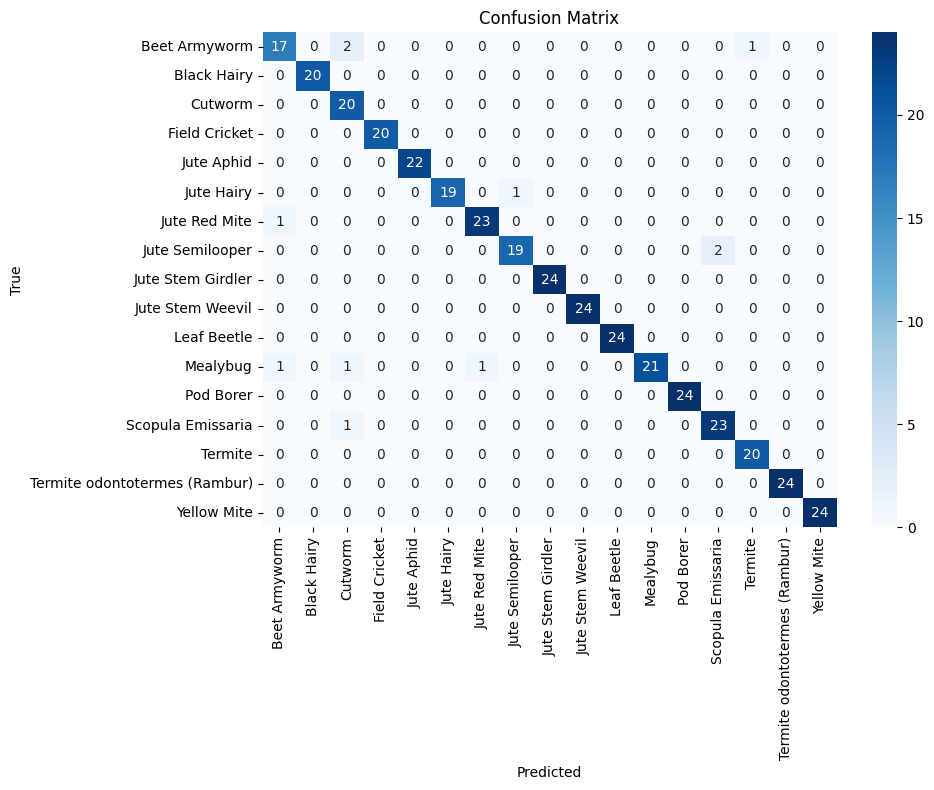


--- Sample Predictions (3 random classes) ---


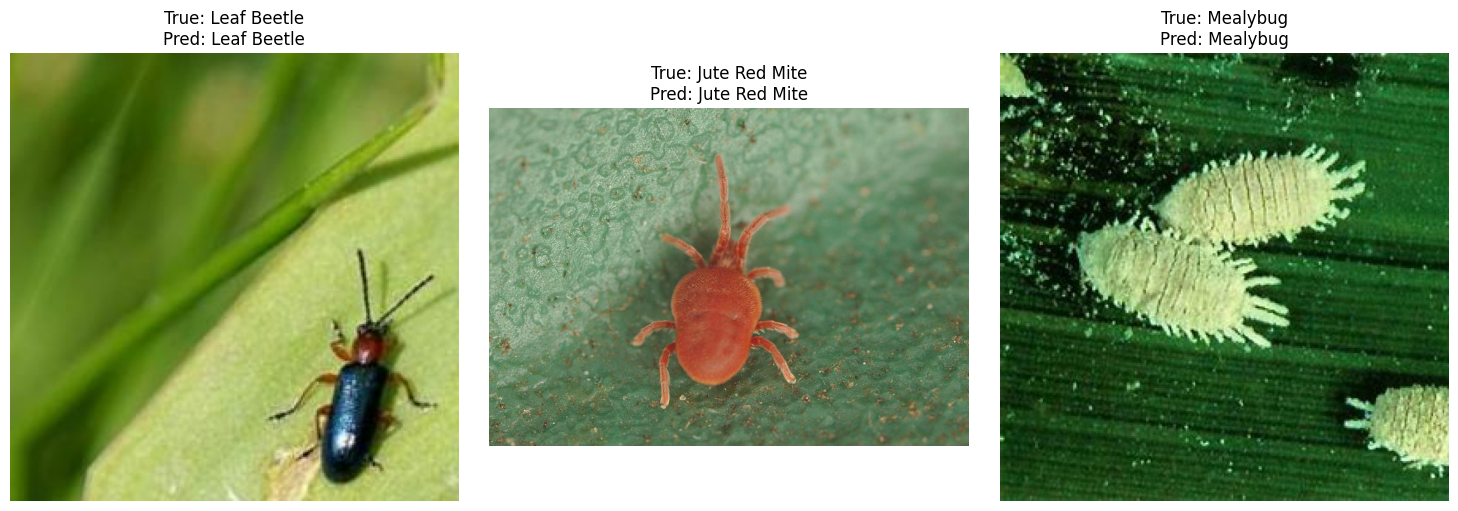

In [ ]:
# === Google Colab: Mount Drive and Copy Dataset ===
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# === Imports ===
import os, time, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# === Paths ===
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# === Dataset Class ===
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === Training Function ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False, dynamic_ncols=True,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "vgg16_best_jute_pest_model.pth"))

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}\n")

# === Transforms ===
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# === Datasets & Dataloaders ===
datasets = {
    "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
    "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
    "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
}

batch_size = 64
num_workers = 8
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size, shuffle=(phase=="train"),
                      num_workers=num_workers, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    for phase in ["train", "val", "test"]
}

# === VGG16 ===
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # freeze convolution layers

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(datasets["train"].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# === Train ===
model, training_logs = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_vgg16_jute_pest_model.pth"))

# === Test ===
model.eval()
test_results, all_preds, all_labels = [], [], []
correct, total, sample_idx = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            test_results.append({
                "image_path": datasets["test"].samples[sample_idx][0],
                "true_label": datasets["test"].classes[labels[i].item()],
                "predicted_label": datasets["test"].classes[predicted[i].item()]
            })
            sample_idx += 1

# Save Results
with open(os.path.join(BASE_DIR, "vgg16_test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# === Metrics ===
print("\n--- Test Metrics ---")
print(f"Test Accuracy : {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision     : {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall        : {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"F1 Score      : {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

# === Confusion Matrix ===
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=datasets["test"].classes,
            yticklabels=datasets["test"].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "vgg16_confusion_matrix.png"))
plt.show()

# === Random Predictions ===
chosen_classes = random.sample(datasets["test"].classes, 3)
chosen_samples = []

for cls in chosen_classes:
    cls_indices = [i for i, sample in enumerate(test_results) if sample["true_label"] == cls]
    if cls_indices:
        chosen_samples.append(test_results[random.choice(cls_indices)])

print("\n--- Sample Predictions (3 random classes) ---")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sample = chosen_samples[i]
    img = Image.open(sample["image_path"])
    ax.imshow(img)
    ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "vgg16_sample_predictions.png"))
plt.show()

# === Save Logs ===
with open(os.path.join(BASE_DIR, "vgg16_training_logs.json"), "w") as f:
    json.dump(training_logs, f, indent=4)


# ***MobileNetV2***

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists
Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=M


Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-10-2d94bd675133>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.8832  Acc: 0.7573


Val Loss: 0.6367  Acc: 0.8087

Epoch 2/10 ====================


Train Loss: 0.3036  Acc: 0.9230


Val Loss: 0.5343  Acc: 0.8450

Epoch 3/10 ====================


Train Loss: 0.2171  Acc: 0.9492


Val Loss: 0.5044  Acc: 0.8475

Epoch 4/10 ====================


Train Loss: 0.1913  Acc: 0.9547


Val Loss: 0.4566  Acc: 0.8862

Epoch 5/10 ====================


Train Loss: 0.1696  Acc: 0.9561


Val Loss: 0.4650  Acc: 0.8644

Epoch 6/10 ====================


Train Loss: 0.1531  Acc: 0.9618


Val Loss: 0.4288  Acc: 0.8886

Epoch 7/10 ====================


Train Loss: 0.1442  Acc: 0.9659


Val Loss: 0.4245  Acc: 0.8886

Epoch 8/10 ====================


Train Loss: 0.1345  Acc: 0.9649


Val Loss: 0.4125  Acc: 0.8838

Epoch 9/10 ====================


Train Loss: 0.1217  Acc: 0.9708


Val Loss: 0.4075  Acc: 0.9031

Epoch 10/10 ====================


Train Loss: 0.1171  Acc: 0.9686


Val Loss: 0.4221  Acc: 0.8886

Training complete in 4m 38s
Best validation accuracy: 0.9031



--- Test Metrics ---
Test Accuracy : 0.9710
Precision     : 0.9730
Recall        : 0.9710
F1 Score      : 0.9710

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.89      0.85      0.87        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.83      1.00      0.91        20
                Field Cricket       1.00      0.95      0.97        20
                   Jute Aphid       0.96      1.00      0.98        22
                   Jute Hairy       1.00      0.90      0.95        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       0.91      0.95      0.93        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

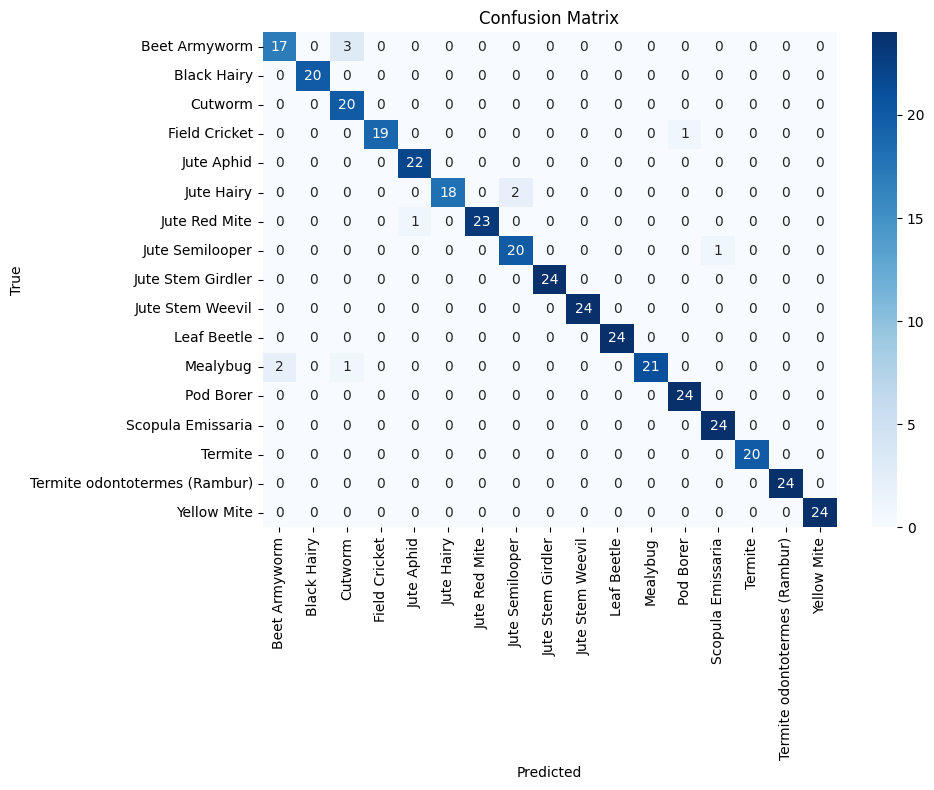


--- Sample Predictions (3 random classes) ---


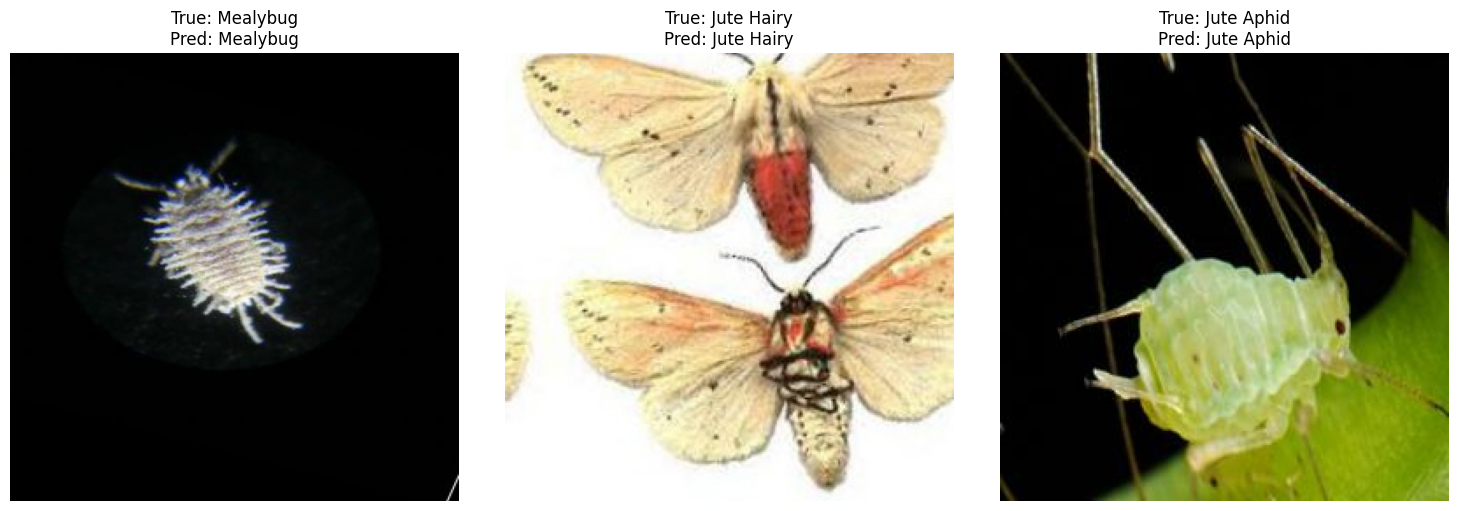

In [ ]:
# === Google Colab: Mount Drive and Copy Dataset ===
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# === Imports ===
import os, time, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# === Paths ===
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# === Dataset Class ===
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === Training Function ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False, dynamic_ncols=True,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "mobilenetv2_best_jute_pest_model.pth"))

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}\n")

# === Transforms ===
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# === Datasets & Dataloaders ===
datasets = {
    "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
    "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
    "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
}

batch_size = 64
num_workers = 8
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size, shuffle=(phase=="train"),
                      num_workers=num_workers, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    for phase in ["train", "val", "test"]
}

# === MobileNetV2 ===
model = models.mobilenet_v2(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(datasets["train"].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# === Train ===
model, training_logs = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_mobilenetv2_jute_pest_model.pth"))

# === Test ===
model.eval()
test_results, all_preds, all_labels = [], [], []
correct, total, sample_idx = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            test_results.append({
                "image_path": datasets["test"].samples[sample_idx][0],
                "true_label": datasets["test"].classes[labels[i].item()],
                "predicted_label": datasets["test"].classes[predicted[i].item()]
            })
            sample_idx += 1

# Save Results
with open(os.path.join(BASE_DIR, "mobilenetv2_test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# === Metrics ===
print("\n--- Test Metrics ---")
print(f"Test Accuracy : {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision     : {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall        : {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"F1 Score      : {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

# === Confusion Matrix ===
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=datasets["test"].classes,
            yticklabels=datasets["test"].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "mobilenetv2_confusion_matrix.png"))
plt.show()

# === Random Predictions ===
chosen_classes = random.sample(datasets["test"].classes, 3)
chosen_samples = []

for cls in chosen_classes:
    cls_indices = [i for i, sample in enumerate(test_results) if sample["true_label"] == cls]
    if cls_indices:
        chosen_samples.append(test_results[random.choice(cls_indices)])

print("\n--- Sample Predictions (3 random classes) ---")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sample = chosen_samples[i]
    img = Image.open(sample["image_path"])
    ax.imshow(img)
    ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "mobilenetv2_sample_predictions.png"))
plt.show()

# === Save Logs ===
with open(os.path.join(BASE_DIR, "mobilenetv2_training_logs.json"), "w") as f:
    json.dump(training_logs, f, indent=4)
